In [1]:
# Required Libraries
import os
import pandas as pd
import json
import glob
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import time
from sklearn import metrics
from itertools import chain
from collections import Counter
import seaborn as sns

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

In [3]:
# Reading all JSON files by folder - participant by just changing the number 22
json_files = glob.glob("Emognition_Dataset/Quantum/28/*.json")

emotion_data = []

for file in json_files:
    with open(file) as f:
        try:
            data = json.load(f)
            if isinstance(data, dict) and "frames" in data:
                emotion_names = []
                frames = data["frames"]
                for frame in frames:
                    if "faces" in frame:
                        faces = frame["faces"]
                        for face in faces:
                            emotion_name = face.get("emotionName")
                            if emotion_name:
                                emotion_names.append(emotion_name)
                if emotion_names:
                    file_name = os.path.splitext(os.path.basename(file))[0]
                    emotion_data.append([file_name, emotion_names])
        except json.JSONDecodeError:
            print(f"Error parsing JSON file: {file}")

In [4]:
# checking the orders while reading
for i in range(10):
    print(emotion_data[i][0])

fear
enthusiasm
surprise
neutral
awe
sadness
disgust
amusement
anger
liking


In [5]:
# Extracting labels from each video clip

clip_label = {}

clip_label['fear'] = np.array(emotion_data[0][1])
clip_label['enthusiasm'] = np.array(emotion_data[1][1])
clip_label['surprise'] = np.array(emotion_data[2][1])
clip_label['neutral'] = np.array(emotion_data[3][1])
clip_label['awe'] = np.array(emotion_data[4][1])
clip_label['sadness'] = np.array(emotion_data[5][1])
clip_label['disgust'] = np.array(emotion_data[6][1])
clip_label['amusement'] = np.array(emotion_data[7][1])
clip_label['anger'] = np.array(emotion_data[8][1])
clip_label['liking'] = np.array(emotion_data[9][1])

In [6]:
# Define the mapping dictionary
emotion_mapping = {
    'anger': 0,
    'disgust': 1,
    'sadness': 2,
    'neutral': 3,
    'surprise': 4,
    'happiness': 5
}

clip_label_int = {}
# Map emotion names to numbers
#clip_label_int['baseline'] = np.array([emotion_mapping[emotion] for emotion in clip_label['baseline']]) # Baseline
clip_label_int['awe'] = np.array([emotion_mapping[emotion] for emotion in clip_label['awe']]) # AWE
clip_label_int['fear'] = np.array([emotion_mapping[emotion] for emotion in clip_label['fear']]) # Fear
clip_label_int['anger'] = np.array([emotion_mapping[emotion] for emotion in clip_label['anger']]) # Anger
clip_label_int['neutral'] = np.array([emotion_mapping[emotion] for emotion in clip_label['neutral']]) # Neutral
clip_label_int['liking'] = np.array([emotion_mapping[emotion] for emotion in clip_label['liking']]) # Liking
clip_label_int['amusement'] = np.array([emotion_mapping[emotion] for emotion in clip_label['amusement']]) # Amusement
clip_label_int['surprise'] = np.array([emotion_mapping[emotion] for emotion in clip_label['surprise']]) # Surprise
clip_label_int['enthusiasm'] = np.array([emotion_mapping[emotion] for emotion in clip_label['enthusiasm']]) # Enthusiasm
clip_label_int['disgust'] = np.array([emotion_mapping[emotion] for emotion in clip_label['disgust']]) # Disgust
clip_label_int['sadness'] = np.array([emotion_mapping[emotion] for emotion in clip_label['sadness']]) # Sadness

In [7]:
# Read the CSV files by folder - participant by just chaniging the number 22

clips_array = ['amusement', 'anger', 'awe', 'disgust', 'enthusiasm', 'fear', 'liking', 'neutral', 'sadness', 'surprise']

dataframes = {}

for clip in clips_array:
    file_path = 'Emognition_Dataset/OpenFace/28/{}.csv'.format(clip)
    dataframes[clip] = pd.read_csv(file_path)

In [8]:
clips_array = ['amusement', 'anger', 'awe', 'disgust', 'enthusiasm', 'fear', 'liking', 'neutral', 'sadness', 'surprise']

# Iterate over each clip
for clip in clips_array:
    # Emotion NumPy arrays
    array1 = clip_label[clip]
    array2 = clip_label_int[clip]

    # Get the number of rows in the DataFrame
    num_rows = len(dataframes[clip])

    # Repeat the existing values in the arrays to match the number of rows
    if num_rows > len(array1):
        num_repeats = num_rows - len(array1)
        repeated_values = np.repeat(array1[-1], num_repeats)
        array1 = np.concatenate([array1, repeated_values])

    if num_rows > len(array2):
        num_repeats = num_rows - len(array2)
        repeated_values = np.repeat(array2[-1], num_repeats)
        array2 = np.concatenate([array2, repeated_values])

    # Add arrays as new columns to the DataFrame
    dataframes[clip]['class'] = array1
    dataframes[clip]['class_int'] = array2

In [10]:
clips_array = ['amusement', 'anger', 'awe', 'disgust', 'enthusiasm', 'fear', 'liking', 'neutral', 'sadness', 'surprise']

anger_df = {}
disgust_df = {}
sadness_df = {}
neutral_df = {}
surprise_df = {}
happiness_df = {}

for clip in clips_array:
    #print("-----------------------------------------------------------------")
    anger_df[clip] = dataframes[clip][dataframes[clip]['class'] == 'anger']
    #print(f"The number of records in {clip} video clip for anger is: {dataframes[clip][dataframes[clip]['class'] == 'anger'].shape[0]}")
    disgust_df[clip] = dataframes[clip][dataframes[clip]['class'] == 'disgust']
    #print(f"The number of records in {clip} video clip for disgust is: {dataframes[clip][dataframes[clip]['class'] == 'disgust'].shape[0]}")
    sadness_df[clip] = dataframes[clip][dataframes[clip]['class'] == 'sadness']
    #print(f"The number of records in {clip} video clip for sadness is: {dataframes[clip][dataframes[clip]['class'] == 'sadness'].shape[0]}")
    neutral_df[clip] = dataframes[clip][dataframes[clip]['class'] == 'neutral']
    #print(f"The number of records in {clip} video clip for neutral is: {dataframes[clip][dataframes[clip]['class'] == 'neutral'].shape[0]}")
    surprise_df[clip] = dataframes[clip][dataframes[clip]['class'] == 'surprise']
    #print(f"The number of records in {clip} video clip for surprise is: {dataframes[clip][dataframes[clip]['class'] == 'surprise'].shape[0]}")
    happiness_df[clip] = dataframes[clip][dataframes[clip]['class'] == 'happiness']
    #print(f"The number of records in {clip} video clip for happiness is: {dataframes[clip][dataframes[clip]['class'] == 'happiness'].shape[0]}")

In [11]:
clips_array = ['amusement', 'anger', 'awe', 'disgust', 'enthusiasm', 'fear', 'liking', 'neutral', 'sadness', 'surprise']

# Create an empty final dataframe
anger_final_df = pd.DataFrame()
disgust_final_df = pd.DataFrame()
sadness_final_df = pd.DataFrame()
neutral_final_df = pd.DataFrame()
surprise_final_df = pd.DataFrame()
happiness_final_df = pd.DataFrame()

# Loop through the dataframes
for clips in clips_array:
    # Append the current dataframe to the final dataframe
    anger_final_df = pd.concat([anger_final_df, anger_df[clips]], ignore_index=True)
    disgust_final_df = pd.concat([disgust_final_df, disgust_df[clips]], ignore_index=True)
    sadness_final_df = pd.concat([sadness_final_df, sadness_df[clips]], ignore_index=True)
    neutral_final_df = pd.concat([neutral_final_df, neutral_df[clips]], ignore_index=True)
    surprise_final_df = pd.concat([surprise_final_df, surprise_df[clips]], ignore_index=True)
    happiness_final_df = pd.concat([happiness_final_df, happiness_df[clips]], ignore_index=True)

In [12]:
print(f"In the final dataframe, the number of records for \033[31m anger \033[0m will be: {anger_final_df.shape[0]}")
print(f"In the final dataframe, the number of records for \033[31m disgust \033[0m will be: {disgust_final_df.shape[0]}")
print(f"In the final dataframe, the number of records for \033[31m sadness \033[0m will be: {sadness_final_df.shape[0]}")
print(f"In the final dataframe, the number of records for \033[31m neutral \033[0m will be: {neutral_final_df.shape[0]}")
print(f"In the final dataframe, the number of records for \033[31m surprise \033[0m will be: {surprise_final_df.shape[0]}")
print(f"In the final dataframe, the number of records for \033[31m happiness \033[0m will be: {happiness_final_df.shape[0]}")

In the final dataframe, the number of records for  anger  will be: 17
In the final dataframe, the number of records for  disgust  will be: 58
In the final dataframe, the number of records for  sadness  will be: 2327
In the final dataframe, the number of records for  neutral  will be: 61107
In the final dataframe, the number of records for  surprise  will be: 410
In the final dataframe, the number of records for  happiness  will be: 203


In [13]:
# Create a list of the dataframes
dfs = [anger_final_df, disgust_final_df, sadness_final_df, neutral_final_df, surprise_final_df, happiness_final_df]

# Concatenate the dataframes
concatenated_df = pd.concat(dfs)

# Reset the index of the concatenated dataframe
concatenated_df.reset_index(drop=True, inplace=True)

In [14]:
# Create a list of the dataframes with a smaller portion of neutral records
n_dfs = [sadness_final_df.sample(n=1600), neutral_final_df.sample(n=1600)]

# Concatenated normalized dataframes
n_concatenated_df = pd.concat(n_dfs)

# Reset the index of the concatenated dataframe
n_concatenated_df.reset_index(drop=True, inplace=True)

# Shuffle the rows of the DataFrame
shuffled_df = n_concatenated_df

In [15]:
index = shuffled_df.columns.get_loc('AU01_r')
print(index)

679


In [16]:
# Define the column ranges
column_ranges = [
    (5, 298),
    (index, 715)
]

# Extract the desired columns
selected_columns = []
for start, end in column_ranges:
    selected_columns.extend(shuffled_df.iloc[:, start:end+1].columns)

# Create a new dataframe with the selected columns
new_df = shuffled_df[selected_columns]

In [17]:
subsets = [
    ['gaze_0_x', 'gaze_1_x'],
    ['gaze_0_y', 'gaze_1_y'],
    ['gaze_0_z', 'gaze_1_z'],
    ['eye_lmk_x_' + str(i) for i in range(56)],
    ['eye_lmk_y_' + str(i) for i in range(56)],
    ['eye_lmk_X_' + str(i) for i in range(56)],
    ['eye_lmk_Y_' + str(i) for i in range(56)],
    ['eye_lmk_Z_' + str(i) for i in range(56)]
]

# Create a new dataframe to store the aggregated features
aggregated_df = pd.DataFrame()

# Define custom column names for the mean columns
mean_column_names = ['gaze_x', 'gaze_y', 'gaze_z', 'eye_lmk_x', 'eye_lmk_y', 'eye_lmk_X', 'eye_lmk_Y', 'eye_lmk_Z']

# Perform mean aggregation for each subset
for subset, column_name in zip(subsets, mean_column_names):
    subset_mean = new_df[subset].mean(axis=1)  # Calculate the mean along the row axis
    aggregated_df[column_name] = subset_mean

# Drop the original features used for aggregation
new_df = new_df.drop(columns=[col for subset in subsets for col in subset])

# Concatenate the aggregated features with the unchanged features
final_df = pd.concat([aggregated_df, new_df], axis=1)

In [18]:
final_df.columns

Index(['gaze_x', 'gaze_y', 'gaze_z', 'eye_lmk_x', 'eye_lmk_y', 'eye_lmk_X',
       'eye_lmk_Y', 'eye_lmk_Z', 'gaze_angle_x', 'gaze_angle_y', 'pose_Tx',
       'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'AU01_r',
       'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r',
       'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r',
       'AU26_r', 'AU45_r', 'AU01_c', 'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c',
       'AU07_c', 'AU09_c', 'AU10_c', 'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c',
       'AU20_c', 'AU23_c', 'AU25_c', 'AU26_c', 'AU28_c', 'AU45_c', 'class',
       'class_int'],
      dtype='object')

In [19]:
features = ['gaze_x', 'gaze_y', 'gaze_z', 'eye_lmk_x', 'eye_lmk_y', 'eye_lmk_X',
       'eye_lmk_Y', 'eye_lmk_Z', 'gaze_angle_x', 'gaze_angle_y', 'pose_Tx',
       'pose_Ty', 'pose_Tz', 'pose_Rx', 'pose_Ry', 'pose_Rz', 'AU01_r',
       'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r',
       'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r',
       'AU26_r', 'AU45_r', 'AU01_c', 'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c',
       'AU07_c', 'AU09_c', 'AU10_c', 'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c',
       'AU20_c', 'AU23_c', 'AU25_c', 'AU26_c', 'AU28_c', 'AU45_c']

## Z-Score

In [20]:
# Z-Score using pandas
for fe in features:
    final_df['{}_Z'.format(fe)] = (final_df[fe] - final_df[fe].mean()) / final_df[fe].std()

In [21]:
features_Z = [fe + '_Z' for fe in features]

In [22]:
final_df['class_int'].unique()

array([2, 3])

# PCA

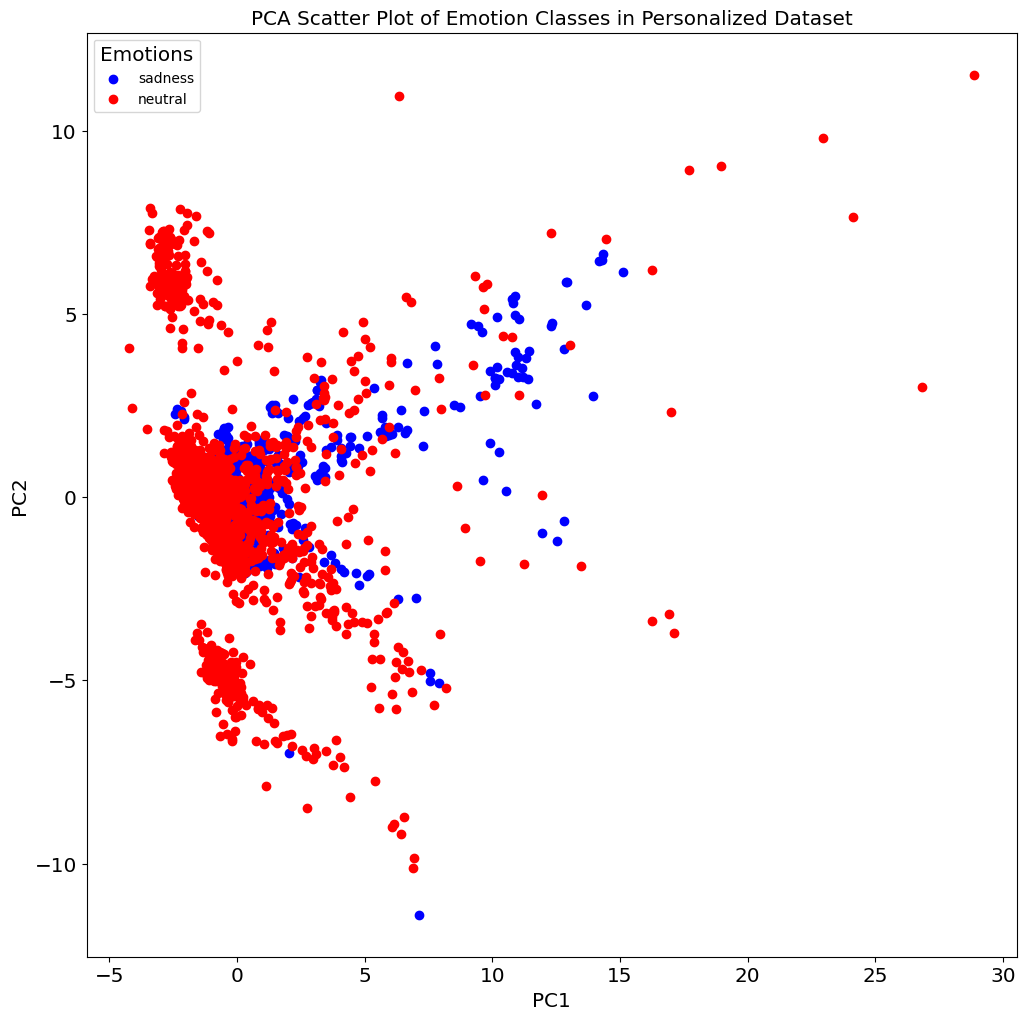

In [23]:
plt.figure(figsize=(12, 12))

# Perform PCA on the feature data
em_pca = PCA(n_components=2)
pca_x = em_pca.fit_transform(final_df[features_Z].values)

# Get unique class labels
em_cat = list(final_df['class'].unique())

# Define custom colormap for the classes
colors = ['blue', 'red', 'green']

# Plot the scatter plot with custom colors
for i, label in enumerate(em_cat):
    class_indices = final_df['class'] == label
    plt.scatter(pca_x[class_indices, 0], pca_x[class_indices, 1], c=colors[i], label=label)

legend = plt.legend(title="Emotions")
legend.get_title().set_fontsize('x-large')  # Increase legend title font size
plt.xlabel('PC1', fontsize='x-large')
plt.ylabel('PC2', fontsize='x-large')
plt.tick_params(labelsize='x-large')  # Increase tick labels font size
plt.title('PCA Scatter Plot of Emotion Classes in Personalized Dataset', fontsize='x-large')  # Adding the title
plt.show()

In [24]:
em_pca = PCA(n_components=40)
em_pca.fit(final_df[features_Z].values)
evro = em_pca.explained_variance_ratio_

# Model Selection

## KNN

In [25]:
y = final_df['class'].values
X = final_df[features_Z].values

### Accuracy

In [26]:
k_selection=range(1,30) #6
cons = RepeatedKFold(n_splits=5, n_repeats=3, random_state=50)
# knn
em_knn = KNeighborsClassifier()
pms={'n_neighbors': k_selection}
em_gs = GridSearchCV(em_knn, pms, cv=cons, return_train_score=False)
em_gs.fit(X,y)
em_gs.best_params_['n_neighbors']
print("Accuracy:", np.max(em_gs.cv_results_['mean_test_score']))

Accuracy: 0.9665625


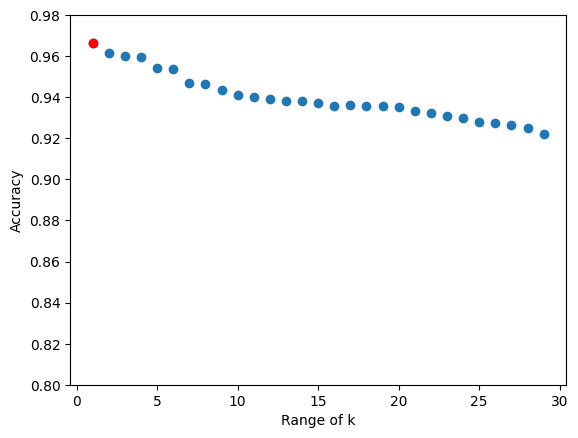

In [27]:
plt.plot(k_selection, em_gs.cv_results_['mean_test_score'],'o')
# highlight the best parameter
plt.plot(em_gs.best_params_['n_neighbors'], np.max(em_gs.cv_results_['mean_test_score']),'ro')
plt.plot()
plt.ylim((0.8,0.98))
plt.xlabel('Range of k')
plt.ylabel('Accuracy');

## Random Forest

In [28]:
y = final_df['class'].values
X = final_df[features_Z].values

In [29]:
rf_clfr = RandomForestClassifier(random_state=20)
cons = RepeatedKFold(n_splits=5, n_repeats=3, random_state=5)

max_depths = [5, 10, 15, 20, None]
max_features = ['sqrt', 'log2', 0.25, 0.5, 0.75, None]
parameters={'max_depth': max_depths,
           'max_features': max_features}

em_gs = GridSearchCV(rf_clfr, parameters, cv=cons, return_train_score=False, n_jobs=-1)
em_gs.fit(X,y)

print('Best hyperparameter combination:')
print('Max Depth:', em_gs.best_params_['max_depth'])
print('Max Feature:', em_gs.best_params_['max_features'])
print("Best accuracy:", np.max(em_gs.cv_results_['mean_test_score']))

Best hyperparameter combination:
Max Depth: 15
Max Feature: sqrt
Best accuracy: 0.9782291666666666


In [30]:
comb_params = list(itertools.product(max_depths, max_features))

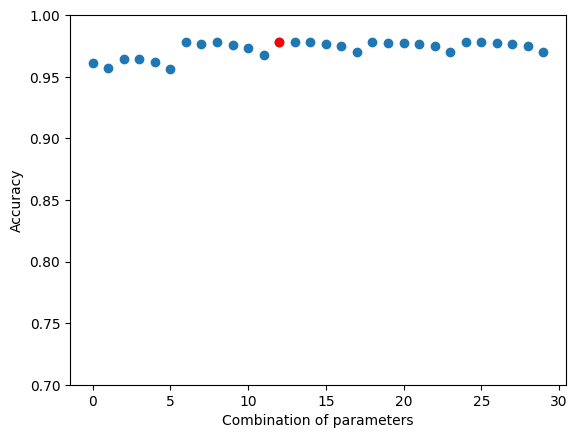

In [31]:
plt.plot(em_gs.cv_results_['mean_test_score'],'o')

ind = np.where((np.array(comb_params)[:,0] == em_gs.best_params_['max_depth']) &
(np.array(comb_params)[:,1] == em_gs.best_params_['max_features']))[0][0]

plt.plot(ind, np.max(em_gs.cv_results_['mean_test_score']),'ro')
plt.plot()
plt.ylim((0.7,1))
plt.xlabel('Combination of parameters')
plt.ylabel('Accuracy');

## MLP

In [32]:
y = final_df['class'].values
X = final_df[features_Z].values

In [33]:
mlp_clfr = MLPClassifier(max_iter=10000, early_stopping=True, random_state=20)

hid_layers_s = [(i,) for i in range(3,8)]
val_frac = [0.1, 0.5]
opt_select = ['adam', 'sgd']
activ_f = ['relu', 'logistic']

parameter_space = {
    'hidden_layer_sizes': hid_layers_s,
    'activation': activ_f,
    'solver': opt_select,
    'validation_fraction': val_frac
}

cons = RepeatedKFold(n_splits=5, n_repeats=3, random_state=5)

# search and select the best hyperparameter combs
em_gs = GridSearchCV(mlp_clfr, parameter_space, cv=cons)
em_gs.fit(X, y)
print('Combination of best hyperparameters:')
em_gs.best_params_
print("Best accuracy:", em_gs.best_score_)

Combination of best hyperparameters:
Best accuracy: 0.9376041666666667


In [34]:
comb_params = list(itertools.product(activ_f, hid_layers_s, opt_select, val_frac))

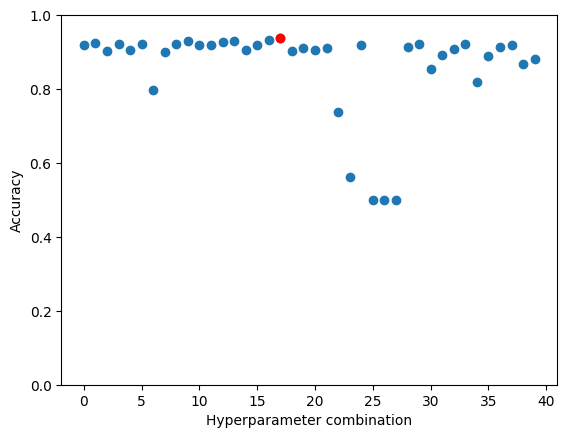

In [35]:
plt.plot(em_gs.cv_results_['mean_test_score'],'o')
# best feature combination
ind = comb_params.index(tuple(em_gs.best_params_.values()))
plt.plot(ind, np.max(em_gs.cv_results_['mean_test_score']),'ro')
plt.plot()
plt.ylim((0,1))
plt.xlabel('Hyperparameter combination')
plt.ylabel('Accuracy');

# Performance Estimation

## KNN

In [51]:
y = final_df['class'].values
X = final_df[features_Z].values

In [52]:
start_time = time.time()

k_selection=range(1,30) 

kfold_outer = KFold(n_splits=10, random_state=10, shuffle=True)
kfold_inner = RepeatedKFold(n_splits=5, n_repeats=3, random_state=50)

# knn classifier
knn_clfr = KNeighborsClassifier()

parameters={'n_neighbors': k_selection}

y_preds_knn = []
y_trues_knn = []
best_hc_knn = []

for train_index, test_index in kfold_outer.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # search and select
    em_gs = GridSearchCV(knn_clfr, parameters, cv=kfold_inner, return_train_score=False)
    em_gs.fit(X_train, y_train)
    # ROAUC
    y_score=em_gs.fit(X_train, y_train).predict_proba(X_test)
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    
    # predict on the the test data useing the selected model
    y_preds_knn.extend(list(em_gs.predict(X_test)))
    y_trues_knn.extend(y_test)
    
    # save the best combination of hyperparameters
    best_hc_knn.append(em_gs.best_params_['n_neighbors'])
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 1081.7289106845856 seconds ---


In [53]:
y_score

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [54]:
label_binarizer.transform(["happiness"])

array([[1, 0, 0]])

In [55]:
class_of_interest = "happiness"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

0

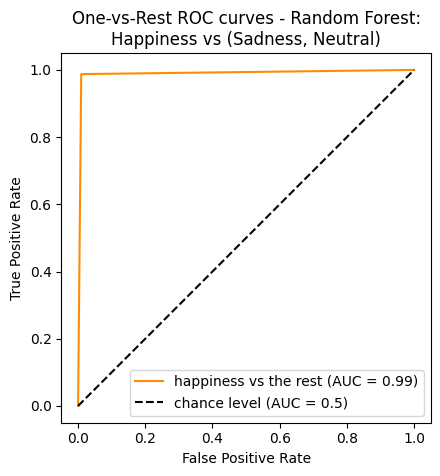

In [56]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves - Random Forest:\nHappiness vs (Sadness, Neutral)")
plt.legend()
plt.show()

In [57]:
print(f"y_score:\n{y_score[0:2,:]}")
print()
print(f"y_score.ravel():\n{y_score[0:2,:].ravel()}")

y_score:
[[0. 0. 1.]
 [0. 0. 1.]]

y_score.ravel():
[0. 0. 1. 0. 0. 1.]


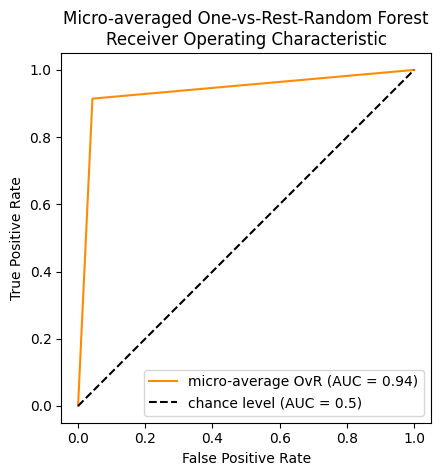

In [58]:
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest-Random Forest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [59]:
from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.94


In [60]:
n_classes = len(np.unique(y))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.93


In [61]:
from sklearn.metrics import roc_auc_score
macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.93


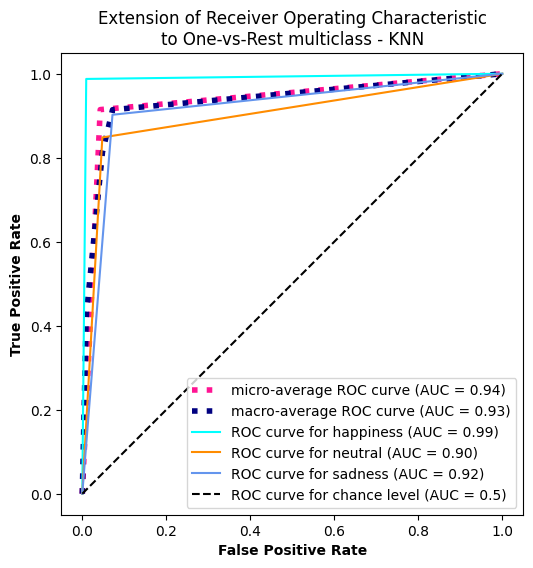

In [63]:
from itertools import cycle
target_names = ["happiness", "neutral", "sadness"]

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate", fontweight='bold')
plt.ylabel("True Positive Rate", fontweight='bold')
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass - KNN")
plt.legend()
plt.show()

Predicted: Happiness Neutral Sadness
True: Happiness 1585 7 8
True: Neutral 25 1381 194
True: Sadness 7 80 1513


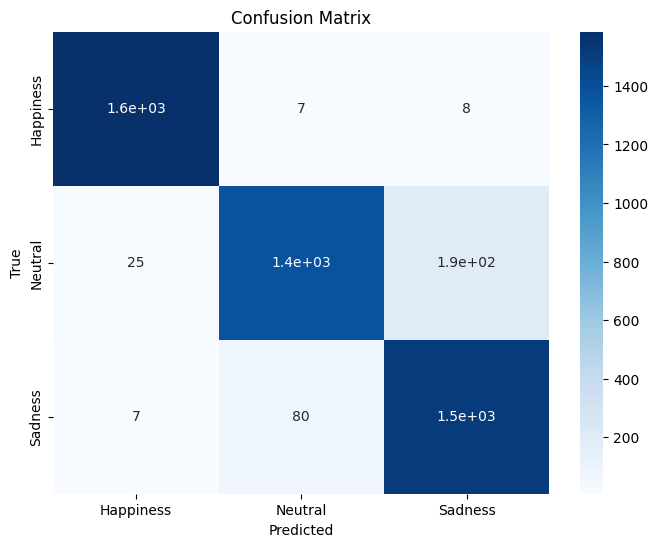

Accuracy: 0.933
best k counts:
1 : 10


In [64]:
# Calculate the confusion matrix
cm = metrics.confusion_matrix(y_trues_knn, y_preds_knn)

# Define the class labels
class_labels = ['Happiness', 'Neutral', 'Sadness']

# Print the predicted and true labels
print('Predicted:', *class_labels)
for i, row in enumerate(cm):
    print('True:', class_labels[i], *row)

# Calculate the accuracy
accuracy = np.round(metrics.accuracy_score(y_trues_knn, y_preds_knn), 3)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the accuracy
print('Accuracy:', accuracy)

print('best k counts:')
for best_k in np.unique(best_hc_knn):
    print(best_k, ':', best_hc_knn.count(best_k))

Confusion Matrix:
Predicted: Happiness Neutral Sadness
True: Happiness  1585     7     8
True: Neutral    25  1381   194
True: Sadness     7    80  1513


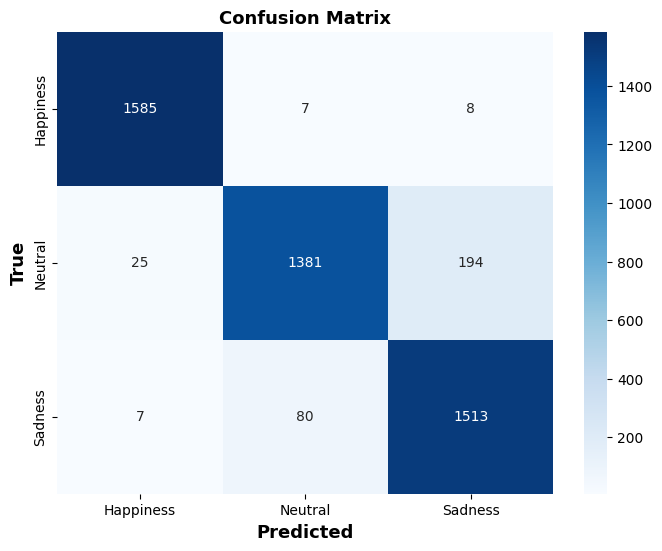

Accuracy: 0.933
best k counts:
1 : 10


In [82]:
# Calculate the confusion matrix
cm = metrics.confusion_matrix(y_trues_knn, y_preds_knn)

# Define the class labels
class_labels = ['Happiness', 'Neutral', 'Sadness']

# Print the confusion matrix with normal formatting
print('Confusion Matrix:')
print('Predicted:', *class_labels)
for i, row in enumerate(cm):
    print('True:', class_labels[i], *[f"{num:5d}" for num in row])

# Calculate the accuracy
accuracy = np.round(metrics.accuracy_score(y_trues_knn, y_preds_knn), 3)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix', fontweight='bold', fontsize=13)
plt.xlabel('Predicted', fontweight='bold', fontsize=13)
plt.ylabel('True', fontweight='bold', fontsize=13)
plt.show()

# Print the accuracy
print('Accuracy:', accuracy)

print('best k counts:')
for best_k in np.unique(best_hc_knn):
    print(best_k, ':', best_hc_knn.count(best_k))

## Random Forest

In [67]:
start_time = time.time()

kfold_outer = KFold(n_splits=10, random_state=10, shuffle=True)
kfold_inner = RepeatedKFold(n_splits=5, n_repeats=3, random_state=50)

max_depths = [20, None]
max_features = ['sqrt', 'log2']
parameters={'max_depth': max_depths,
           'max_features': max_features}

rf_clfr = RandomForestClassifier(random_state=20)

y_preds = []
y_trues = []
best_p = []

for train_index, test_index in kfold_outer.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # select the best model
    em_gs = GridSearchCV(rf_clfr, parameters, cv=kfold_inner, return_train_score=False)
    em_gs.fit(X_train, y_train)
    # ROAUC
    y_score_rf=em_gs.fit(X_train, y_train).predict_proba(X_test)
    label_binarizer_rf = LabelBinarizer().fit(y_train)
    y_onehot_test_rf = label_binarizer.transform(y_test)
    
    # use the selected model to predict the classes for the test data
    y_preds.extend(list(em_gs.predict(X_test)))
    y_trues.extend(y_test)
    
    # save the best hyperparameter combination
    best_p.append(em_gs.best_params_)
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 710.1911141872406 seconds ---


In [68]:
y_score_rf

array([[0.05, 0.09, 0.86],
       [0.  , 0.04, 0.96],
       [0.  , 0.04, 0.96],
       ...,
       [0.98, 0.01, 0.01],
       [0.96, 0.03, 0.01],
       [0.95, 0.  , 0.05]])

In [69]:
label_binarizer_rf.transform(["happiness"])

array([[1, 0, 0]])

In [70]:
class_of_interest = "happiness"
class_id = np.flatnonzero(label_binarizer_rf.classes_ == class_of_interest)[0]
class_id

0

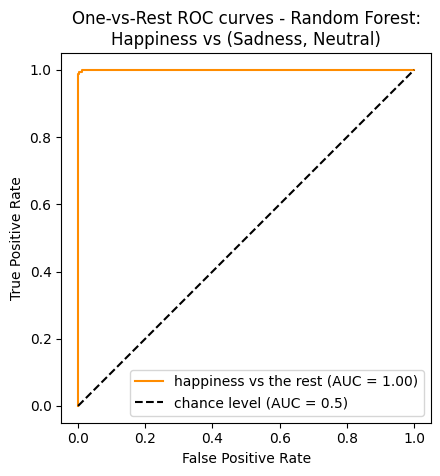

In [71]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test_rf[:, class_id],
    y_score_rf[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves - Random Forest:\nHappiness vs (Sadness, Neutral)")
plt.legend()
plt.show()

In [72]:
print(f"y_score:\n{y_score_rf[0:2,:]}")
print()
print(f"y_score.ravel():\n{y_score_rf[0:2,:].ravel()}")

y_score:
[[0.05 0.09 0.86]
 [0.   0.04 0.96]]

y_score.ravel():
[0.05 0.09 0.86 0.   0.04 0.96]


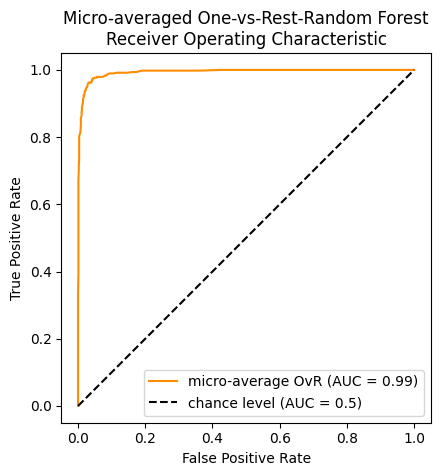

In [73]:
RocCurveDisplay.from_predictions(
    y_onehot_test_rf.ravel(),
    y_score_rf.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest-Random Forest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [74]:
from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test_rf.ravel(), y_score_rf.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.99


In [75]:
n_classes = len(np.unique(y))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test_rf[:, i], y_score_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.99


In [76]:
from sklearn.metrics import roc_auc_score
macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score_rf,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.99


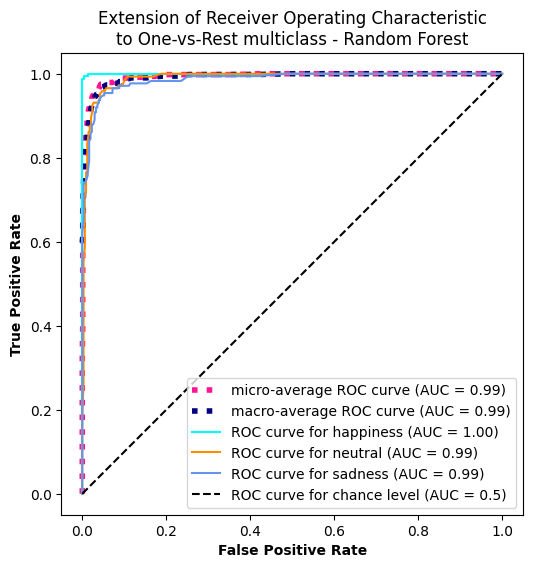

In [78]:
from itertools import cycle
target_names = ["happiness", "neutral", "sadness"]

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test_rf[:, class_id],
        y_score_rf[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate", fontweight='bold')
plt.ylabel("True Positive Rate", fontweight='bold')
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass - Random Forest")
plt.legend()
plt.show()

Predicted: Happiness Neutral Sadness
True: Happiness 1596 1 3
True: Neutral 19 1455 126
True: Sadness 8 70 1522


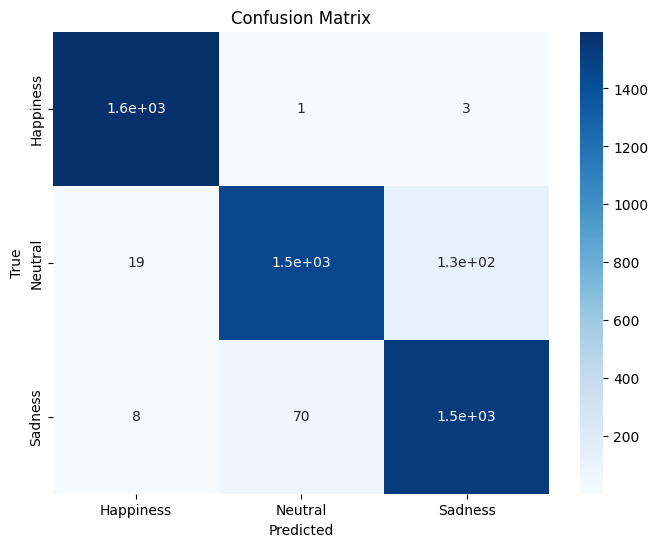

Accuracy: 0.953
Combinations of Best Parameters:
(max_depth, max_features): number of counts


Counter({(None, 'log2'): 3,
         (20, 'sqrt'): 1,
         (None, 'sqrt'): 2,
         (20, 'log2'): 4})

In [79]:
# Calculate the confusion matrix
cm = metrics.confusion_matrix(y_trues, y_preds)

# Define the class labels
class_labels = ['Happiness', 'Neutral', 'Sadness']

# Print the predicted and true labels
print('Predicted:', *class_labels)
for i, row in enumerate(cm):
    print('True:', class_labels[i], *row)

# Calculate the accuracy
accuracy = np.round(metrics.accuracy_score(y_trues, y_preds), 3)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the accuracy
print('Accuracy:', accuracy)

# Print the combinations of best parameters
print('Combinations of Best Parameters:')
print('(max_depth, max_features): number of counts')
par1 = [i['max_depth'] for i in best_p]
par2 = [i['max_features'] for i in best_p]
pars = list(zip(par1, par2))
Counter(pars)

Confusion Matrix:
Predicted: Happiness Neutral Sadness
True: Happiness  1596     1     3
True: Neutral    19  1455   126
True: Sadness     8    70  1522


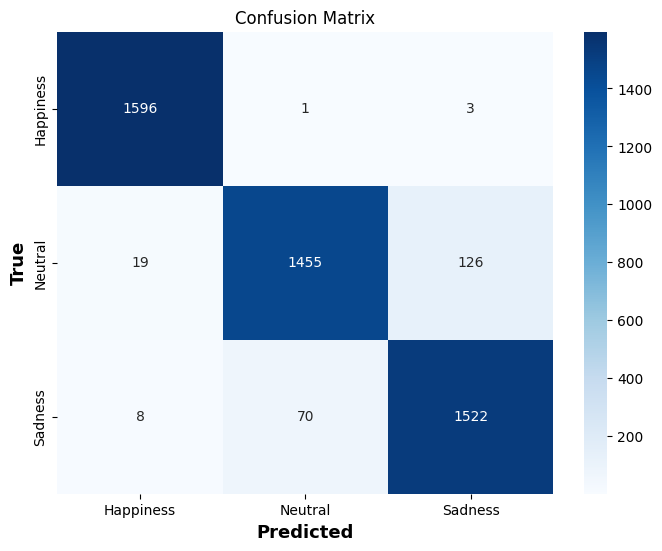

Accuracy: 0.953
Combinations of Best Parameters:
(max_depth, max_features): number of counts
(None, 'log2'): 3
(20, 'sqrt'): 1
(None, 'sqrt'): 2
(20, 'log2'): 4


In [80]:
from collections import Counter

# Calculate the confusion matrix
cm = metrics.confusion_matrix(y_trues, y_preds)

# Define the class labels
class_labels = ['Happiness', 'Neutral', 'Sadness']

# Print the confusion matrix with normal formatting
print('Confusion Matrix:')
print('Predicted:', *class_labels)
for i, row in enumerate(cm):
    print('True:', class_labels[i], *[f"{num:5d}" for num in row])

# Calculate the accuracy
accuracy = np.round(metrics.accuracy_score(y_trues, y_preds), 3)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted', fontweight='bold', fontsize=13)
plt.ylabel('True', fontweight='bold', fontsize=13)
plt.show()

# Print the accuracy
print('Accuracy:', accuracy)

# Print the combinations of best parameters with normal formatting
print('Combinations of Best Parameters:')
print('(max_depth, max_features): number of counts')
par1 = [i['max_depth'] for i in best_p]
par2 = [i['max_features'] for i in best_p]
pars = list(zip(par1, par2))
for par, count in Counter(pars).items():
    print(f"{par}: {count}")


## MLP

In [81]:
start_time = time.time()

hid_layers_s = [(i,) for i in range(3,6)]
val_frac = [0.1, 0.5]
opt_select = ['adam', 'sgd']
activ_f = ['relu', 'logistic']

parameters = {
    'hidden_layer_sizes': hid_layers_s,
    'activation': activ_f,
    'solver': opt_select,
    'validation_fraction': val_frac
}

kfold_outer = KFold(n_splits=10, random_state=10, shuffle=True)
kfold_inner = RepeatedKFold(n_splits=5, n_repeats=3, random_state=50)

mlp_clfr = MLPClassifier(max_iter=10000, early_stopping=True, random_state=20)

y_preds_mlp = []
y_trues_mlp = []
best_p_mlp = []

for train_index, test_index in kfold_outer.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # select the best model
    em_gs = GridSearchCV(mlp_clfr, parameters, cv=kfold_inner, return_train_score=False)
    em_gs.fit(X_train, y_train)
    
    # ROAUC
    y_score_mlp=em_gs.fit(X_train, y_train).predict_proba(X_test)
    label_binarizer_mlp = LabelBinarizer().fit(y_train)
    y_onehot_test_mlp = label_binarizer.transform(y_test)
    
    # use the selected model to predict the classes for the test data
    y_preds_mlp.extend(list(em_gs.predict(X_test)))
    y_trues_mlp.extend(y_test)
    
    # save the best hyperparameter combination
    best_p_mlp.append(em_gs.best_params_)
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 10802.205061674118 seconds ---


In [83]:
y_score_mlp

array([[0.06107131, 0.12392768, 0.81500101],
       [0.06107131, 0.12392768, 0.81500101],
       [0.06107131, 0.12392768, 0.81500101],
       ...,
       [0.98289682, 0.00869452, 0.00840866],
       [0.80991028, 0.07441468, 0.11567504],
       [0.98455463, 0.006935  , 0.00851038]])

In [84]:
label_binarizer_mlp.transform(["happiness"])

array([[1, 0, 0]])

In [85]:
class_of_interest = "happiness"
class_id = np.flatnonzero(label_binarizer_mlp.classes_ == class_of_interest)[0]
class_id

0

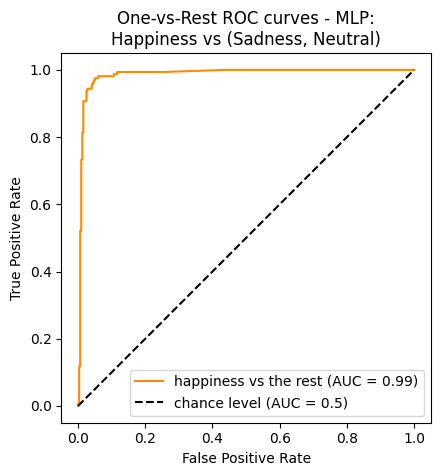

In [86]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test_mlp[:, class_id],
    y_score_mlp[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves - MLP:\nHappiness vs (Sadness, Neutral)")
plt.legend()
plt.show()

In [87]:
print(f"y_score:\n{y_score_mlp[0:2,:]}")
print()
print(f"y_score.ravel():\n{y_score_mlp[0:2,:].ravel()}")

y_score:
[[0.06107131 0.12392768 0.81500101]
 [0.06107131 0.12392768 0.81500101]]

y_score.ravel():
[0.06107131 0.12392768 0.81500101 0.06107131 0.12392768 0.81500101]


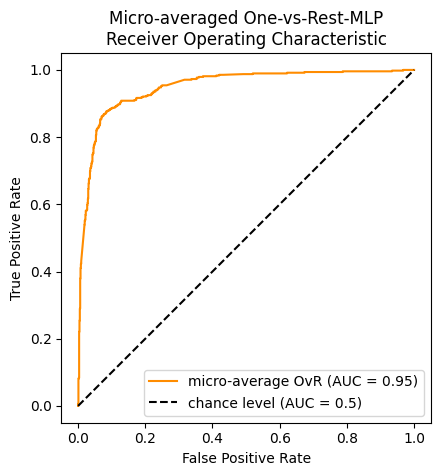

In [88]:
RocCurveDisplay.from_predictions(
    y_onehot_test_mlp.ravel(),
    y_score_mlp.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest-MLP\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [89]:
from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test_mlp.ravel(), y_score_mlp.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.95


In [90]:
n_classes = len(np.unique(y))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test_mlp[:, i], y_score_mlp[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.94


In [91]:
from sklearn.metrics import roc_auc_score
macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score_mlp,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.94


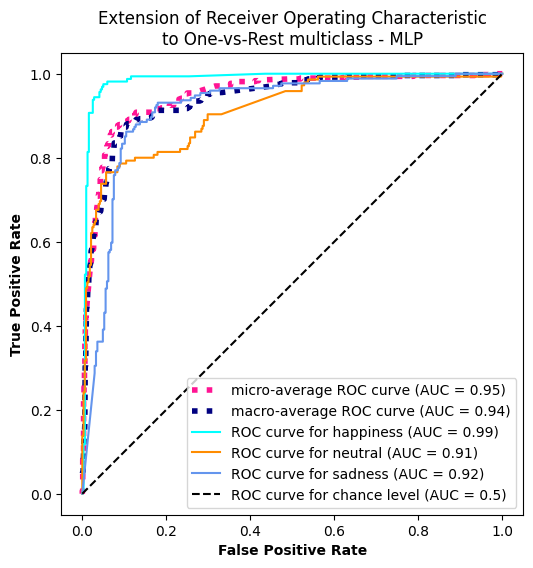

In [93]:
from itertools import cycle
target_names = ["happiness", "neutral", "sadness"]

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test_mlp[:, class_id],
        y_score_mlp[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate", fontweight='bold')
plt.ylabel("True Positive Rate", fontweight='bold')
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass - MLP")
plt.legend()
plt.show()

Predicted: Happiness Neutral Sadness
True: Happiness 1570 9 21
True: Neutral 71 1258 271
True: Sadness 84 224 1292


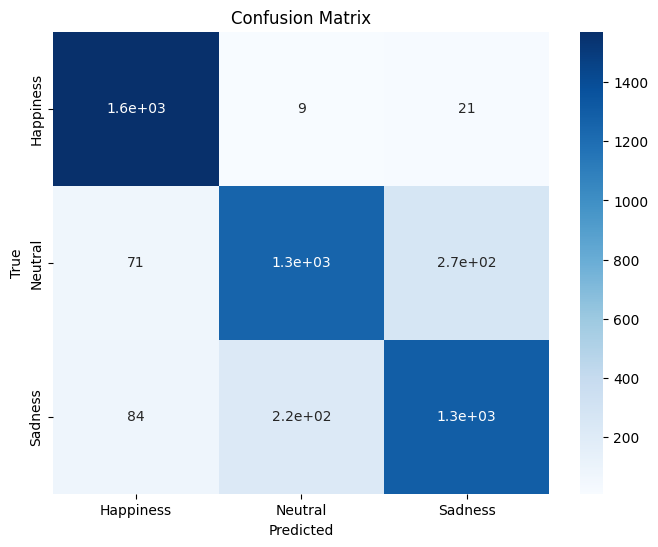

Accuracy: 0.858
Combinations of Best Parameters:
(activation functions, hidden_layer_sizes, solver - optimizer, validation_frac): number of counts


Counter({('relu', (3,), 'adam', 0.5): 7, ('relu', (3,), 'adam', 0.1): 3})

In [94]:
# Calculate the confusion matrix
cm = metrics.confusion_matrix(y_trues_mlp, y_preds_mlp)

# Define the class labels
class_labels = ['Happiness', 'Neutral', 'Sadness']

# Print the predicted and true labels
print('Predicted:', *class_labels)
for i, row in enumerate(cm):
    print('True:', class_labels[i], *row)

# Calculate the accuracy
accuracy = np.round(metrics.accuracy_score(y_trues_mlp, y_preds_mlp), 3)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the accuracy
print('Accuracy:', accuracy)

print('Combinations of Best Parameters:')
print('(activation functions, hidden_layer_sizes, solver - optimizer, validation_frac): number of counts')
Counter([tuple(best_p_mlp[i].values()) for i in range(len(best_p_mlp))])

Confusion Matrix:
Predicted: Happiness Neutral Sadness
True: Happiness  1570     9    21
True: Neutral    71  1258   271
True: Sadness    84   224  1292


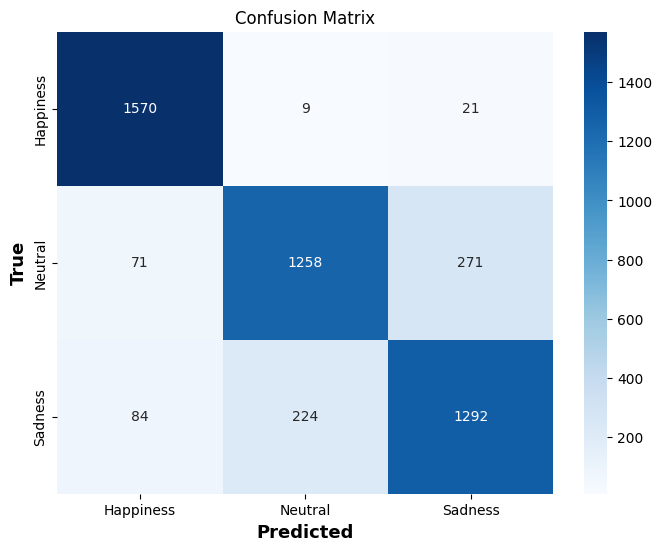

Accuracy: 0.858
Combinations of Best Parameters:
(activation functions, hidden_layer_sizes, solver - optimizer, validation_frac): number of counts
('relu', (3,), 'adam', 0.5): 7
('relu', (3,), 'adam', 0.1): 3


In [95]:
from collections import Counter

# Calculate the confusion matrix
cm = metrics.confusion_matrix(y_trues_mlp, y_preds_mlp)

# Define the class labels
class_labels = ['Happiness', 'Neutral', 'Sadness']

# Print the confusion matrix with normal formatting
print('Confusion Matrix:')
print('Predicted:', *class_labels)
for i, row in enumerate(cm):
    print('True:', class_labels[i], *[f"{num:5d}" for num in row])

# Calculate the accuracy
accuracy = np.round(metrics.accuracy_score(y_trues_mlp, y_preds_mlp), 3)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted', fontsize=13, fontweight='bold')
plt.ylabel('True', fontsize=13, fontweight='bold')
plt.show()

# Print the accuracy
print('Accuracy:', accuracy)

# Print the combinations of best parameters with normal formatting
print('Combinations of Best Parameters:')
print('(activation functions, hidden_layer_sizes, solver - optimizer, validation_frac): number of counts')
best_p_mlp_combinations = [tuple(best_p_mlp[i].values()) for i in range(len(best_p_mlp))]
for par, count in Counter(best_p_mlp_combinations).items():
    print(f"{par}: {count}")